In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

df = pd.read_csv("Original/RentingOutofFlats.csv")

In [2]:
df.head()

,rent_approval_date,town,block,street_name,flat_type,monthly_rent
0,2021-01,ANG MO KIO,105,ANG MO KIO AVE 4,4-ROOM,2000
1,2021-01,ANG MO KIO,107,ANG MO KIO AVE 4,3-ROOM,1750
2,2021-01,ANG MO KIO,108,ANG MO KIO AVE 4,3-ROOM,1750
3,2021-01,ANG MO KIO,111,ANG MO KIO AVE 4,5-ROOM,2230
4,2021-01,ANG MO KIO,111,ANG MO KIO AVE 4,5-ROOM,2450


In [3]:
# Check for missing data
df.isnull().sum()

rent_approval_date    0
town                  0
block                 0
street_name           0
flat_type             0
monthly_rent          0
dtype: int64

In [4]:
# Check for duplicates
"""
print(df.duplicated().sum()) # number of duplicated rows that should be removed
df_dup = df[df.duplicated()] # df showing the duplicated rows that should be removed
df_dup.head()
"""

# Remove duplicates
df_cleaned = df.drop_duplicates(subset=None, inplace=False)

In [5]:
# Convert to appropriate data type
#df_cleaned.dtypes

df_cleaned = df_cleaned.astype('string')

df_cleaned['monthly_rent'] = df_cleaned['monthly_rent'].astype('int32')
df_cleaned['rent_approval_date'] = pd.to_datetime(df_cleaned['rent_approval_date'])
#df_cleaned['rent_approval_date'] = df_cleaned['rent_approval_date'].dt.to_period('M')

df_cleaned.dtypes

rent_approval_date    datetime64[ns]
town                          string
block                         string
street_name                   string
flat_type                     string
monthly_rent                   int32
dtype: object

In [6]:
df_cleaned.head()

,rent_approval_date,town,block,street_name,flat_type,monthly_rent
0,2021-01-01,ANG MO KIO,105,ANG MO KIO AVE 4,4-ROOM,2000
1,2021-01-01,ANG MO KIO,107,ANG MO KIO AVE 4,3-ROOM,1750
2,2021-01-01,ANG MO KIO,108,ANG MO KIO AVE 4,3-ROOM,1750
3,2021-01-01,ANG MO KIO,111,ANG MO KIO AVE 4,5-ROOM,2230
4,2021-01-01,ANG MO KIO,111,ANG MO KIO AVE 4,5-ROOM,2450


In [7]:
# Check consistency in categories
for col in ['town', 'flat_type']:
    print(f'{col}:', sorted(df[col].unique()))

town: ['ANG MO KIO', 'BEDOK', 'BISHAN', 'BUKIT BATOK', 'BUKIT MERAH', 'BUKIT PANJANG', 'BUKIT TIMAH', 'CENTRAL', 'CHOA CHU KANG', 'CLEMENTI', 'GEYLANG', 'HOUGANG', 'JURONG EAST', 'JURONG WEST', 'KALLANG/WHAMPOA', 'MARINE PARADE', 'PASIR RIS', 'PUNGGOL', 'QUEENSTOWN', 'SEMBAWANG', 'SENGKANG', 'SERANGOON', 'TAMPINES', 'TOA PAYOH', 'WOODLANDS', 'YISHUN']
flat_type: ['1-ROOM', '2-ROOM', '3-ROOM', '4-ROOM', '5-ROOM', 'EXECUTIVE']


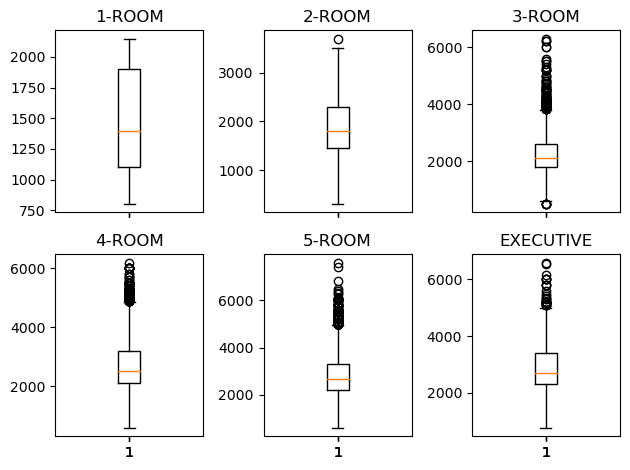

In [8]:
# Check for outliers (but not removing them)
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=True)

flats = sorted(df['flat_type'].unique())
for index, flat in enumerate(flats):
    a = index//3
    b = index%3
    flat_data = df_cleaned[df_cleaned['flat_type'] == flat]
    ax[a, b].boxplot(flat_data['monthly_rent'])
    ax[a, b].set_title(flat)

plt.tight_layout()
plt.show()

# Despite the super wide range of values, data seems to be for whole flats and not just one bedroom.
# References: 
# - https://services2.hdb.gov.sg/webapp/BR12AWRentalEnq/BR12PSearch.jsp (for rental of whole flats - checked that certain outliers are in here)
# - https://www.hdb.gov.sg/residential/renting-a-flat/renting-from-the-open-market/rental-statistics (median prices from dataset match these - mostly within $50 deviation)

In [9]:
# How many outliers? (using IQR method)
Q1 = df_cleaned['monthly_rent'].quantile(0.25)
Q3 = df_cleaned['monthly_rent'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df_cleaned[(df_cleaned['monthly_rent'] < lower_bound) | (df_cleaned['monthly_rent'] > upper_bound)]
print(f'Outliers: {outliers.shape[0]} ({100*outliers.shape[0]/df_cleaned.shape[0]:.3f}%)')

Outliers: 905 (0.828%)


In [10]:
# Add lat, lng
hdb_locations = pd.read_csv('Additional/sg_zipcode_mapper_utf.csv')
hdb_locations = hdb_locations.loc[hdb_locations['postal'] == hdb_locations['postal.1']]
hdb_locations.drop(['Unnamed: 0', 'postal', 'searchval', 'building', 'address', 'postal.1'], axis='columns', inplace=True)

df_cne = df_cleaned.merge(hdb_locations, on=['block', 'street_name'], how='left')
df_cne.isnull().sum()

rent_approval_date       0
town                     0
block                    0
street_name              0
flat_type                0
monthly_rent             0
lat                   3241
lng                   3241
dtype: int64

In [11]:
# Find missing lat, lng data
missing = df_cne[df_cne['lat'].isnull()]
missing.to_csv('missing.csv')

In [12]:
# Impute missing lat, lng data (https://www.geoapify.com/tools/geocoding-online)
geoapify = pd.read_csv('Additional/missing_geoapify.csv')
df_cne = df_cne.merge(geoapify, on=['block', 'street_name'], how='left', suffixes=(None, '_geo'))
df_cne['lat'] = df_cne['lat'].fillna(df_cne['lat_geo'])
df_cne['lng'] = df_cne['lng'].fillna(df_cne['lng_geo'])
df_cne.drop(['lat_geo', 'lng_geo'], axis='columns', inplace=True)

df_cne.isnull().sum()

rent_approval_date    0
town                  0
block                 0
street_name           0
flat_type             0
monthly_rent          0
lat                   0
lng                   0
dtype: int64

In [13]:
# Functions for nearest MRT
from math import sin, cos, sqrt, atan2, radians

def earth_distance(x, y):

  # Approximate radius of earth in km
  R = 6373.0

  lat1, lng1 = radians(x[0]), radians(x[1])
  lat2, lng2 = radians(y[0]), radians(y[1])

  dlon = lng2 - lng1
  dlat = lat2 - lat1

  a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
  c = 2 * atan2(sqrt(a), sqrt(1 - a))

  return R * c

def euclidean_distance(x, y):
  dx = x[0] - y[0]
  dy = x[1] - y[1]

  return sqrt(dx**2 + dy**2)

In [14]:
# Add nearest MRT
mrt_locations = pd.read_csv("Additional/mrt_data.csv")
mrt_locations.drop(columns=['type'], inplace=True)

from sklearn.neighbors import KNeighborsClassifier

X = mrt_locations.drop('station_name', axis=1)
y = mrt_locations['station_name']

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X, y)
df_cne['nearest_mrt'] = knn.predict(df_cne[['lat', 'lng']])

df_cne = df_cne.merge(mrt_locations, left_on='nearest_mrt', right_on='station_name', how='left', suffixes=(None, '_mrt'))
df_cne['mrt_dist'] = df_cne.apply(lambda row: earth_distance([row.lat_mrt, row.lng_mrt], [row.lat, row.lng]), axis=1)
df_cne.drop(['lat_mrt', 'lng_mrt', 'station_name'], axis='columns', inplace=True)
df_cne.head()

,rent_approval_date,town,block,street_name,flat_type,monthly_rent,lat,lng,nearest_mrt,mrt_dist
0,2021-01-01,ANG MO KIO,105,ANG MO KIO AVE 4,4-ROOM,2000,1.372313,103.837601,Yio Chu Kang,1.329716
1,2021-01-01,ANG MO KIO,107,ANG MO KIO AVE 4,3-ROOM,1750,1.371384,103.837381,Ang Mo Kio,1.365741
2,2021-01-01,ANG MO KIO,108,ANG MO KIO AVE 4,3-ROOM,1750,1.370966,103.838202,Ang Mo Kio,1.270434
3,2021-01-01,ANG MO KIO,111,ANG MO KIO AVE 4,5-ROOM,2230,1.370851,103.837298,Ang Mo Kio,1.369690
4,2021-01-01,ANG MO KIO,111,ANG MO KIO AVE 4,5-ROOM,2450,1.370851,103.837298,Ang Mo Kio,1.369690


In [16]:
# Import resale dataset
"""resale_df = pd.DataFrame()
csv_files = ['Original/ResaleFlatPricesBasedonApprovalDate19901999.csv',
            'Original/ResaleFlatPricesBasedonApprovalDate2000Feb2012.csv',
            'Original/ResaleFlatPricesBasedonRegistrationDateFromMar2012toDec2014.csv',
            'Original/ResaleFlatPricesBasedonRegistrationDateFromJan2015toDec2016.csv',
            'Original/ResaleflatpricesbasedonregistrationdatefromJan2017onwards.csv']
 
for file in csv_files:
    df_temp = pd.read_csv(file)
    resale_df = pd.concat([resale_df, df_temp], ignore_index=True)"""

# Rewritten cuz original resale files too big to upload
resale_df = pd.read_csv('Original/resale_df1.csv')
df_temp = pd.read_csv('Original/resale_df2.csv')
resale_df = pd.concat([resale_df, df_temp], ignore_index=True)

resale_df['flat_type'] = resale_df['flat_type'].str.replace(' ROOM', '-ROOM')
resale_df.drop_duplicates(subset=None, inplace=True)
#resale_df.drop(['month', 'storey_range', 'flat_model', 'remaining_lease', 'resale_price'], axis='columns', inplace=True)

In [21]:
# Try to enrich using resale dataset - floor area & lease commence date
# Match to flat_type, block, and street_name
resale_median = pd.DataFrame(resale_df.groupby(['flat_type', 'block', 'street_name']).median())
df_cne2 = df_cne.merge(resale_median, on=['flat_type', 'block', 'street_name'], how='left', suffixes=(None, '_1'))

# Fill missing lease_commence_date values using median of data with same block & street_name
resale_copy = resale_df.drop_duplicates(subset=['block', 'street_name'], inplace=False)
df_cne2 = df_cne2.merge(resale_copy, on=['block', 'street_name'], how='left', suffixes=(None, '_2'))
df_cne2['lease_commence_date'] = df_cne2['lease_commence_date'].fillna(df_cne2['lease_commence_date_2'])
df_cne2.drop(['floor_area_sqm_2', 'lease_commence_date_2', 'town_2', 'flat_type_2'], axis='columns', inplace=True)
df_cne2.drop(['Unnamed: 0', 'Unnamed: 0_2'], axis='columns', inplace=True)

# Can't fill missing lease_commence_date values using median of data with same street_name because variation can be quite large
# Can't fill missing floor_area_sqm values using median of data with same flat_type & street_name because variation can be quite large
# Python libraries typically exclude data points with missing data in the columns involved in the plot
# Therefore, can ignore small % of missing values in the additional columns

C:\Users\Cayden\AppData\Local\Temp\ipykernel_23940\2483455007.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  resale_median = pd.DataFrame(resale_df.groupby(['flat_type', 'block', 'street_name']).median())


In [22]:
print(df_cne2.shape)
df_cne2.isnull().sum() # can ignore small % of missing values in the additional columns

(109285, 12)


rent_approval_date       0
town                     0
block                    0
street_name              0
flat_type                0
monthly_rent             0
lat                      0
lng                      0
nearest_mrt              0
mrt_dist                 0
floor_area_sqm         374
lease_commence_date    274
dtype: int64

In [25]:
# Add rental price per sqm & flat_age
df_cne2['price_per_sqm'] = df_cne2['monthly_rent'] / df_cne2['floor_area_sqm']
df_cne2['flat_age'] = df_cne2['rent_approval_date'].dt.year - df_cne2['lease_commence_date']

In [28]:
df_cne2.to_csv('rental_cleaned.csv')